<a href="https://colab.research.google.com/github/Joovvhan/korean-stt/blob/master/notebooks/CTC_train_eval_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torch.nn as nn
from torch import optim
from torch.autograd import Variable

import os
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import librosa
import random
import copy

from tqdm import tqdm_notebook as tqdm
from datetime import datetime

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
n_mels = 80
fs = 44100
frame_length_ms=50
frame_shift_ms=25
nsc = int(fs * frame_length_ms / 1000)
nov = nsc - int(fs * frame_shift_ms / 1000)
nhop = int(fs * frame_shift_ms / 1000)
eps = 1e-8
db_ref = 160

meta_path = 'gdrive/My Drive/korean-single-speaker-speech-dataset/transcript.v.1.2.txt'
data_folder = 'gdrive/My Drive/korean-single-speaker-speech-dataset/kss'


with open(meta_path, encoding='utf-8') as f:
    metadata = np.array([line.strip().split('|') for line in f])

max_sequence_len = max(list(map(len, metadata[:, 1])))

error_jamos = [5868, 5998, 6046, 6155, 6202, 
               6654, 6890, 7486, 7502, 7744, 
               7765, 8267, 9069, 9927, 10437, 
               10515, 10533, 10606, 10610, 12777]

print(metadata.shape)
metadata = np.delete(metadata, error_jamos, axis = 0)
print(metadata.shape)

dataset_size = len(metadata)

(12853, 5)
(12833, 5)


In [0]:
character_length = list()
file_length = list()
division_length = list()
unicode_jamo_list = list()

for i in range(len(metadata)):
    character_length.append(len(metadata[i, 3]))
    file_length.append(float(metadata[i, 4]))
    division_length.append(float(metadata[i, 4]) * 1000 / len(metadata[i, 3]))

In [0]:
wave_name_list = []

for data in metadata:
    wave_name_list.append(data[0])

In [6]:
unicode_jamo_list = list()
for unicode in range(0x1100, 0x1113):
    unicode_jamo_list.append(chr(unicode))
    
for unicode in range(0x1161, 0x1176):
    unicode_jamo_list.append(chr(unicode))
    
for unicode in range(0x11A8, 0x11C3):
    unicode_jamo_list.append(chr(unicode))
    
unicode_jamo_list += [' ', '!', ',', '.', '?', '<sos>', '<eos>']
    
unicode_jamo_list.sort()

unicode_jamo_list = ['-'] + unicode_jamo_list

print(unicode_jamo_list)
print(len(unicode_jamo_list))

['-', ' ', '!', ',', '.', '<eos>', '<sos>', '?', 'ᄀ', 'ᄁ', 'ᄂ', 'ᄃ', 'ᄄ', 'ᄅ', 'ᄆ', 'ᄇ', 'ᄈ', 'ᄉ', 'ᄊ', 'ᄋ', 'ᄌ', 'ᄍ', 'ᄎ', 'ᄏ', 'ᄐ', 'ᄑ', 'ᄒ', 'ᅡ', 'ᅢ', 'ᅣ', 'ᅤ', 'ᅥ', 'ᅦ', 'ᅧ', 'ᅨ', 'ᅩ', 'ᅪ', 'ᅫ', 'ᅬ', 'ᅭ', 'ᅮ', 'ᅯ', 'ᅰ', 'ᅱ', 'ᅲ', 'ᅳ', 'ᅴ', 'ᅵ', 'ᆨ', 'ᆩ', 'ᆪ', 'ᆫ', 'ᆬ', 'ᆭ', 'ᆮ', 'ᆯ', 'ᆰ', 'ᆱ', 'ᆲ', 'ᆳ', 'ᆴ', 'ᆵ', 'ᆶ', 'ᆷ', 'ᆸ', 'ᆹ', 'ᆺ', 'ᆻ', 'ᆼ', 'ᆽ', 'ᆾ', 'ᆿ', 'ᇀ', 'ᇁ', 'ᇂ']
75


In [0]:
class Tokenizer():
    def __init__(self, vocabs):
        self.vocabs = vocabs
        
    def word2num(self, sentence):
        tokens = list()
        for char in sentence:
            tokens.append(self.vocabs.index(char))    
        return tokens
        
    def word2vec(self, sentence):
        vectors = np.zeros((len(sentence), len(self.vocabs)))
        for i, char in enumerate(sentence):
            vectors[i, self.vocabs.index(char)] = 1   
        return vectors
    
    def num2word(self, num):
        output = list()
        for i in num:
            output.append(self.vocabs[i])
        return output
    
    def num2vec(self, numbers):
        vectors = np.zeros((len(numbers), len(self.vocabs)))
        for i, num in enumerate(numbers):
            vectors[i, num] = 1   
        return vectors

In [0]:
tokenizer = Tokenizer(unicode_jamo_list)
jamo_tokens = tokenizer.word2num(unicode_jamo_list)

In [9]:
mel_path_list = list()

for i, wav_name in enumerate(tqdm(wave_name_list)):
    
    npy_name = wav_name.replace('.wav', '.npy')
    wav_path = os.path.join(data_folder, wav_name)  
    mel_path = os.path.join(data_folder + '/mel', npy_name)
    mel_path_list.append(mel_path)
    
    if not os.path.isfile(mel_path):
#         print("{}".format(mel_path))
        y, sr = librosa.core.load(wav_path)
        f, t, Zxx = sp.signal.stft(y, fs=sr, nperseg=nsc, noverlap=nov)
        Sxx = np.abs(Zxx)
        Sxx = np.maximum(Sxx, eps)

        # plt.figure(figsize=(20,20))
        # plt.imshow(20*np.log10(Sxx), origin='lower')
        # plt.colorbar()
        # plt.show()

        mel_filters = librosa.filters.mel(sr=fs, n_fft=nsc, n_mels=n_mels)
        mel_specgram = np.matmul(mel_filters, Sxx)

    #   log_specgram = 20*np.log10(Sxx)
    #   norm_log_specgram = (log_specgram + db_ref) / db_ref

        log_mel_specgram = 20 * np.log10(np.maximum(mel_specgram, eps))
        norm_log_mel_specgram = (log_mel_specgram + db_ref) / db_ref

    #   np.save(specgram_path, norm_log_specgram)
        np.save(mel_path, norm_log_mel_specgram)
    #   np.save(specgram_path, Sxx)

    #     print(norm_log_mel_specgram.shape[1])

    #     if i % 1000 == 0:
    #         plt.figure(figsize=(8, 4))
    #         plt.imshow(20 * np.log10(Sxx), origin='lower', aspect='auto')
    #         plt.colorbar()
    #         plt.show()

    #         plt.figure(figsize=(8, 4))
    #         plt.imshow(norm_log_mel_specgram, origin='lower', aspect='auto')
    #         plt.colorbar()
    #         plt.show()    

In [0]:
class ResidualGRU(nn.Module):
    def __init__(self, D_in, bidirectional=True):
        super(ResidualGRU, self).__init__()
        self.gru = nn.GRU(D_in, int(D_in/2), bidirectional=bidirectional, batch_first=True)
        self.relu = nn.ReLU()
        
    def forward(self, input_tensor):
        
#         print("Residual Input: {}".format(input_tensor.shape))
        gru_output, _ = self.gru(input_tensor)
        activated = self.relu(gru_output)  
#         print("Residual Output: {}".format(activated.shape))
        output_tensor = torch.add(activated, input_tensor)
        
        return output_tensor

In [0]:
class Encoder(nn.Module):
    def __init__(self, D_in, H):
        super(Encoder, self).__init__()
        self.H = H
        
        self.fc = torch.nn.Linear(D_in, H)
        self.relu = torch.nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        
        self.gru = nn.GRU(H, int(H/2), bidirectional=True, batch_first=True)

    def forward(self, input_tensor):
            
        output_tensor = self.fc(input_tensor)
        output_tensor = self.relu(output_tensor)
        output_tensor = self.dropout(output_tensor)
        
        output_tensor, _ = self.gru(output_tensor)
        
        return output_tensor
    
class CTC_Decoder(nn.Module):
    def __init__(self, H, D_out):
        super(CTC_Decoder, self).__init__()
        self.H = H
        
        self.fc_embed = nn.Linear(H, H)
        self.relu_embed = torch.nn.ReLU()
        self.dropout_embed = nn.Dropout(p=0.5)
        
        self.gru = nn.GRU(H, D_out, batch_first=True)
        
        self.fc = nn.Linear(D_out, 75)
        self.log_softmax = nn.LogSoftmax(dim=2)

    def forward(self, input_tensor):

        output_tensor = self.fc_embed(input_tensor)
        output_tensor = self.relu_embed(output_tensor)
        output_tensor = self.dropout_embed(output_tensor)
        
        output_tensor,_ = self.gru(input_tensor)

        output_tensor = self.fc(output_tensor)
        
        prediction_tensor = self.log_softmax(output_tensor)

        return prediction_tensor

class Mel2SeqNet():
    def __init__(self, D_in, H, D_out):
        super(Mel2SeqNet, self).__init__()
        
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        
        self.H = H
        
        self.encoder = Encoder(D_in, H).to(device)
        self.embedding_layer = nn.Embedding(len(jamo_tokens), 256).to(device)
        self.decoder = CTC_Decoder(H, D_out).to(device)

        self.encoder_optimizer = optim.Adam(self.encoder.parameters(), lr=0.001)
        self.decoder_optimizer = optim.Adam(self.decoder.parameters(), lr=0.001)
        self.embedding_optimizer = optim.Adam(self.embedding_layer.parameters(), lr=0.001)

#         self.criterion = nn.CrossEntropyLoss(reduction='none').to(device)
        self.ctc_loss = nn.CTCLoss().to(device)
        
        for param in self.encoder.parameters():
            param.data.uniform_(-0.1, 0.1)
        for param in self.embedding_layer.parameters():
            param.data.uniform_(-0.1, 0.1)
        for param in self.decoder.parameters():
            param.data.uniform_(-0.1, 0.1)

    def train(self, input_tensor, ground_truth, loss_mask, target_lengths):
        
        batch_size = input_tensor.shape[0]

        self.encoder_optimizer.zero_grad()
        self.decoder_optimizer.zero_grad()
        self.embedding_optimizer.zero_grad()

        encoded_tensor = self.encoder(input_tensor)

        pred_tensor = self.decoder(encoded_tensor)
            
        truth = ground_truth
        truth = truth.type(torch.cuda.LongTensor)
        
        pred_tensor = pred_tensor.permute(1, 0, 2)
        
        input_lengths = torch.full(size=(batch_size,), fill_value=pred_tensor.shape[0], dtype=torch.long)
        
#         print(pred_tensor)

        loss = self.ctc_loss(pred_tensor, truth, input_lengths, target_lengths)

        loss.backward()

        self.encoder_optimizer.step()
        self.decoder_optimizer.step()
        self.embedding_optimizer.step()
        
        return pred_tensor, loss.item() / ground_truth.shape[1]
    
    def save(self, check_point_name):
        torch.save({
            'embedding_layer_state_dict': self.embedding_layer.state_dict(),
            'encoder_state_dict': self.encoder.state_dict(),
            'decoder_state_dict': self.decoder.state_dict(),
            'embedding_optimizer_state_dict': self.embedding_optimizer.state_dict(),
            'encoder_optimizer_state_dict': self.encoder_optimizer.state_dict(),
            'decoder_optimizer_state_dict': self.decoder_optimizer.state_dict(),
            }, check_point_name)
    
    def load(self, check_point_name):
        checkpoint = torch.load(check_point_name)
        self.embedding_layer.load_state_dict(checkpoint['embedding_layer_state_dict'])
        self.encoder.load_state_dict(checkpoint['encoder_state_dict'])
        self.decoder.load_state_dict(checkpoint['decoder_state_dict'])
        self.embedding_optimizer.load_state_dict(checkpoint['embedding_optimizer_state_dict'])
        self.encoder_optimizer.load_state_dict(checkpoint['encoder_optimizer_state_dict'])
        self.decoder_optimizer.load_state_dict(checkpoint['decoder_optimizer_state_dict'])
    
        self.embedding_layer.eval()
        self.encoder.eval()
        self.decoder.eval()
        
        self.embedding_layer.train()
        self.encoder.train()
        self.decoder.train()
        
    def set_mode(self, mode):
        
        if mode == 'train':
            self.embedding_layer.train()
            self.encoder.train()
            self.decoder.train()
            
        elif mode == 'eval':
            self.embedding_layer.eval()
            self.encoder.eval()
            self.decoder.eval()
            
        else:
            print("Invalid mode string: {}".format(mode))
    
# net = Mel2SeqNet(80, 512, 256)

net = Mel2SeqNet(80, 1024, 512)

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")      
print(device)

cuda:0


In [0]:
class Batched_Preloader():
    def __init__(self, mel_path_list, ground_truth_list, batch_size):
        super(Batched_Preloader).__init__()
        self.mel_path_list = mel_path_list
        self.total_num_input = len(mel_path_list)
        self.tensor_input_list = [None] * self.total_num_input
        self.ground_truth_list = ground_truth_list
        self.sentence_length_list = np.asarray(list(map(len, ground_truth_list)))
#         self.shuffle_step = 4
        self.shuffle_step = 12
        self.loading_sequence = None
        self.end_flag = True
        self.batch_size = batch_size
    
    def load(self, i):
        norm_log_mel_specgram = np.load(self.mel_path_list[i])
        input_spectrogram = norm_log_mel_specgram.T
        tensor_input = torch.tensor(input_spectrogram).view(1, input_spectrogram.shape[0], input_spectrogram.shape[1])
        self.tensor_input_list[i] = tensor_input
        
    def get(self, i):
        if type(self.tensor_input_list[i]) == type(None):
            self.load(i)
        return self.tensor_input_list[i]  
    
    
    def initialize_preloader(self):
        for i in tqdm(range(self.total_num_input)):
            self.load(i)
        
        return
    
    def initialize_batch(self):
        loading_sequence = np.argsort(self.sentence_length_list)
        bundle = np.stack([self.sentence_length_list[loading_sequence], loading_sequence])
        
        for seq_len in range(self.shuffle_step, np.max(self.sentence_length_list), self.shuffle_step):
            idxs = np.where((bundle[0, :] > seq_len) & (bundle[0, :] <= seq_len + self.shuffle_step))[0]
            idxs_origin = copy.deepcopy(idxs)
            random.shuffle(idxs)
            bundle[:, idxs_origin] = bundle[:, idxs]
            
        loading_sequence = bundle[1, :]
        
        self.loading_sequence = loading_sequence
        self.current_loading_index = 0
        self.end_flag = False
        
        return
    
    def get_batch(self):
        
        tensor_list = list()
        ground_truth_list = list()
        tensor_size_list = list()
        ground_truth_size_list = list()
        
        count = 0
        max_seq_len = 0
        max_sen_len = 0
        
        for i in range(self.batch_size):
            
            if self.current_loading_index >= self.total_num_input:
                self.end_flag = True
                break
            
            tensor = self.get(self.loading_sequence[self.current_loading_index])
            tensor_list.append(tensor)
            tensor_size_list.append(tensor.shape[1])
            
            ground_truth = self.ground_truth_list[self.loading_sequence[self.current_loading_index]]
            ground_truth_list.append(ground_truth)
            ground_truth_size_list.append(len(ground_truth))
            
            
            if (tensor.shape[1] > max_seq_len):
                max_seq_len = tensor.shape[1]
            if (len(ground_truth) > max_sen_len):
                max_sen_len = len(ground_truth)  
            
            self.current_loading_index += 1
            count += 1
            
        batched_tensor = torch.zeros(count, max_seq_len + 5, n_mels)
        batched_ground_truth = torch.zeros(count, max_sen_len)
        batched_loss_mask = torch.zeros(count, max_sen_len)
        ground_truth_size_list = torch.tensor(np.asarray(ground_truth_size_list), dtype=torch.long)
        
        for order in range(count):
            
            target = tensor_list[order]
        
            pad_random = np.random.randint(0, 5)
            
            if pad_random > 0:
                offset = torch.zeros(target.shape[0], pad_random, target.shape[2])
                target = torch.cat((offset, target), 1)
                
            target = target + (torch.rand(target.shape) - 0.5) / 20
        
            target = torch.clamp(target, min=0.0, max=1.0)
            
            batched_tensor[order, :tensor_size_list[order] + pad_random, :] = target
            batched_ground_truth[order, :ground_truth_size_list[order]] = torch.tensor(ground_truth_list[order])
            batched_loss_mask[order, :ground_truth_size_list[order]] = torch.ones(ground_truth_size_list[order])
        
        return batched_tensor, batched_ground_truth, batched_loss_mask, ground_truth_size_list


In [0]:
ground_truth_list = [(tokenizer.word2num(list(metadata[i, 3]) + ['<eos>'])) for i in range(len(metadata))]

In [19]:
print(len(mel_path_list))

print(len(ground_truth_list))

split_index = int(0.8 * len(mel_path_list))

print(split_index)

mel_path_list_train = mel_path_list[:split_index]
ground_truth_list_train = ground_truth_list[:split_index]

print(len(mel_path_list_train))

mel_path_list_test = mel_path_list[split_index:]
ground_truth_list_test = ground_truth_list[split_index:]

print(len(mel_path_list_test))

12833
12833
10266
10266
2567


In [0]:
# preloader = Batched_Preloader(mel_path_list, ground_truth_list, 64)

preloader_test = Batched_Preloader(mel_path_list_test, ground_truth_list_test, 128)
preloader_test.initialize_preloader()

preloader_train = Batched_Preloader(mel_path_list_train, ground_truth_list_train, 128)
preloader_train.initialize_preloader()

In [0]:
def Decode_CTC_Prediction(prediction):
    CTC_pred = prediction.detach().cpu().numpy()
    result = list()
    last_elem = 0
    for i, elem in enumerate(CTC_pred):
        if elem != last_elem and elem != 0:
            result.append(elem)
        
        last_elem = elem
        
    
    result = np.asarray(result)
    
    return result

In [0]:
loss_history_train = list()
loss_history_eval = list()

try:
    loss_history_train = np.load('gdrive/My Drive/korean-single-speaker-speech-dataset/kss/model_saved/loss_history_train.npy').tolist()
    loss_history_eval = np.load('gdrive/My Drive/korean-single-speaker-speech-dataset/kss/model_saved/loss_history_eval.npy').tolist()
except:
    print("Loading Failed")

Loading Failed


08-31 12:12:43
Mean Loss: 0.07727522079804179
-------------------------------------------------------------------------------------------------------
08-31 12:13:05
Mean Loss: 0.07571637846301571
-------------------------------------------------------------------------------------------------------
08-31 12:13:26
Mean Loss: 0.07539500194593107
-------------------------------------------------------------------------------------------------------
08-31 12:13:48
Mean Loss: 0.07486263571254727
-------------------------------------------------------------------------------------------------------
08-31 12:14:09
Mean Loss: 0.07455207489830266
-------------------------------------------------------------------------------------------------------
08-31 12:14:30
Mean Loss: 0.06980374971373572
-------------------------------------------------------------------------------------------------------
08-31 12:14:52
Mean Loss: 0.06317775486884766
------------------------------------------------------

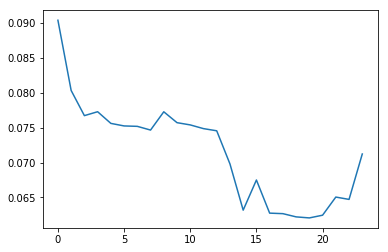

아-------------아------아--아-으-으--아--아--ᄋ--으---------ᅡ-아-아----ᅡ-으--아--ᅡ-----아------아-----아-아-아-아---ᄋ--아-------------------------------------------------------------ᅵ다.<eos><eos>
아아아아으으아아ᄋ으ᅡ아아ᅡ으아ᅡ아아아아아아ᄋ아ᅵ다.<eos>
그녀는 자신의 재능을 이용해 명예와 부를 추구하는 데는 아무 관심이 없었다.<eos>------------------


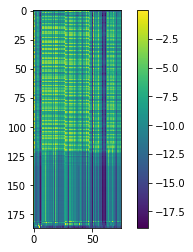

-------------------------------------------------------------------------------------------------------
08-31 12:18:27
Mean Loss: 0.06632340615117524
-------------------------------------------------------------------------------------------------------
08-31 12:18:48
Mean Loss: 0.06745282563991767
-------------------------------------------------------------------------------------------------------
08-31 12:19:09
Mean Loss: 0.06867469776538776
-------------------------------------------------------------------------------------------------------
08-31 12:19:31
Mean Loss: 0.07542892504370645
-------------------------------------------------------------------------------------------------------
08-31 12:19:52
Mean Loss: 0.07495146248770496
-------------------------------------------------------------------------------------------------------
08-31 12:20:13
Mean Loss: 0.07457184992814525
----------------------------------------------------------------------------------------------------

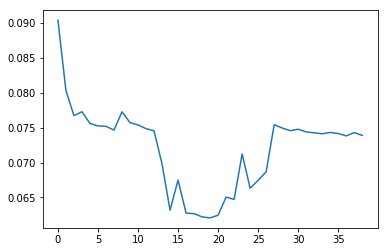

아ᄂ----------------------------------------------------------------------------------------------------------------------------------------------------------------------- 아--------ᆻ다.<eos><eos>
아ᄂ 았다.<eos>
국제연합의 공식 언어는 아랍어, 중국어, 영어, 불어, 러시아어, 스페인어이다.<eos>-----------------


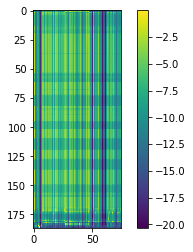

-------------------------------------------------------------------------------------------------------
08-31 12:23:45
Mean Loss: 0.07404945569528532
-------------------------------------------------------------------------------------------------------
08-31 12:24:06
Mean Loss: 0.07369719782808154
-------------------------------------------------------------------------------------------------------
08-31 12:24:27
Mean Loss: 0.07350845482967665
-------------------------------------------------------------------------------------------------------
08-31 12:24:48
Mean Loss: 0.07335962336105656
-------------------------------------------------------------------------------------------------------
08-31 12:25:09
Mean Loss: 0.07371587625989653
-------------------------------------------------------------------------------------------------------
08-31 12:25:30
Mean Loss: 0.07336396644788726
----------------------------------------------------------------------------------------------------

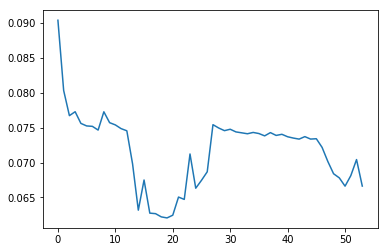

아---------으--으--아--아--아--아--아--아--아--아--아--아--아--아--아--아--아--아--아--아--아--아--아--아--아--아--아---았-----------------------------------------------------------다.<eos><eos>
아으으아아아아아아아아아아아아아아아아아아아아아아아아아았다.<eos>
그녀는 자신의 재능을 이용해 명예와 부를 추구하는 데는 아무 관심이 없었다.<eos>------------------


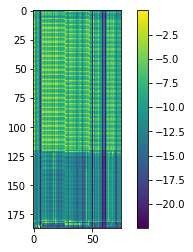

-------------------------------------------------------------------------------------------------------
08-31 12:29:01
Mean Loss: 0.07155703209609349
-------------------------------------------------------------------------------------------------------
08-31 12:29:23
Mean Loss: 0.07222529566529587
-------------------------------------------------------------------------------------------------------
08-31 12:29:44
Mean Loss: 0.06832973820116128
-------------------------------------------------------------------------------------------------------
08-31 12:30:05
Mean Loss: 0.06404002087120012
-------------------------------------------------------------------------------------------------------
08-31 12:30:26
Mean Loss: 0.06362754357214911
-------------------------------------------------------------------------------------------------------
08-31 12:30:46
Mean Loss: 0.06451404102938127
----------------------------------------------------------------------------------------------------

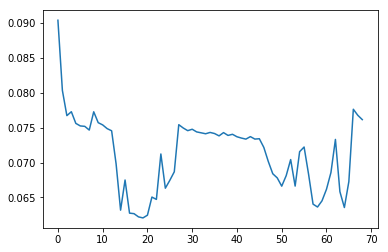

아ᄂ----------------------------------------------------------------------------------------------------------------------------------------------------------------ᄋᆻ다.<eos><eos>
아ᄂᄋᆻ다.<eos>
그녀는 자신의 재능을 이용해 명예와 부를 추구하는 데는 아무 관심이 없었다.<eos>------------------


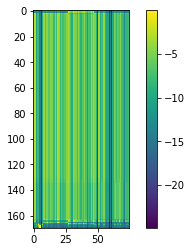

-------------------------------------------------------------------------------------------------------
08-31 12:34:17
Mean Loss: 0.07632639516103426
-------------------------------------------------------------------------------------------------------
08-31 12:34:38
Mean Loss: 0.07572948233666339
-------------------------------------------------------------------------------------------------------
08-31 12:34:58
Mean Loss: 0.07660019853329025
-------------------------------------------------------------------------------------------------------
08-31 12:35:19
Mean Loss: 0.07560647179843609
-------------------------------------------------------------------------------------------------------
08-31 12:35:40
Mean Loss: 0.07622668339963005
-------------------------------------------------------------------------------------------------------
08-31 12:36:00
Mean Loss: 0.07671446440475505
----------------------------------------------------------------------------------------------------

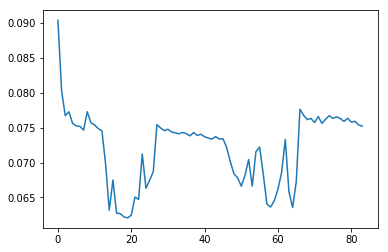

아ᄂ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------ᄋᆻ다.<eos><eos>
아ᄂᄋᆻ다.<eos>
이 수의 십의 자리 숫자는 일의 자리 숫자의 세 배이다. 각 숫자의 합은 팔이다. 이 수는?<eos>---------


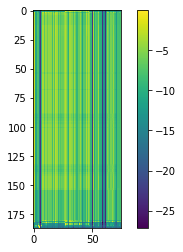

-------------------------------------------------------------------------------------------------------
08-31 12:39:28
Mean Loss: 0.07531750090414698
-------------------------------------------------------------------------------------------------------
08-31 12:39:49
Mean Loss: 0.07524776483485156
-------------------------------------------------------------------------------------------------------
08-31 12:40:10
Mean Loss: 0.07514044765898127
-------------------------------------------------------------------------------------------------------
08-31 12:40:30
Mean Loss: 0.07484372964073675
-------------------------------------------------------------------------------------------------------
08-31 12:40:51
Mean Loss: 0.07493526060848402
-------------------------------------------------------------------------------------------------------
08-31 12:41:12
Mean Loss: 0.07490591707701488
----------------------------------------------------------------------------------------------------

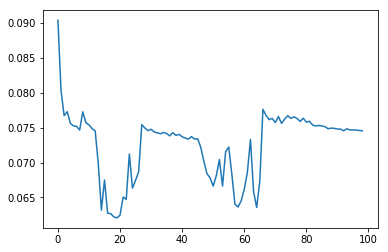

아ᄂ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------ᄋᆻ다.<eos><eos>
아ᄂᄋᆻ다.<eos>
저는 낯을 많이 가려서 새로운 사람들에게 마음을 여는 데 많은 시간이 걸려요.<eos>----------------


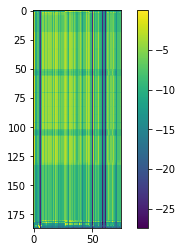

-------------------------------------------------------------------------------------------------------
08-31 12:44:40
Mean Loss: 0.07437279845395699
-------------------------------------------------------------------------------------------------------
08-31 12:45:00
Mean Loss: 0.0745513260540897
-------------------------------------------------------------------------------------------------------
08-31 12:45:21
Mean Loss: 0.07443286011650278
-------------------------------------------------------------------------------------------------------
08-31 12:45:43
Mean Loss: 0.0743694266373582
-------------------------------------------------------------------------------------------------------
08-31 12:46:04
Mean Loss: 0.07421551528039214
-------------------------------------------------------------------------------------------------------
08-31 12:46:24
Mean Loss: 0.07422248266638529
------------------------------------------------------------------------------------------------------

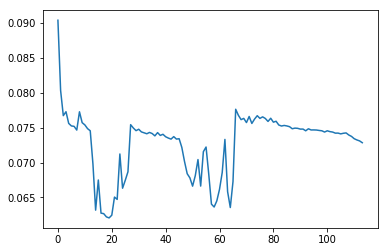

아ᄂ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------어요.<eos><eos>
아ᄂ어요.<eos>
기증품이 계속 들어오면서 우리는 저장 공간이 부족하다는 사실을 깨달았어요.<eos>----------------


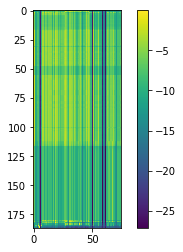

-------------------------------------------------------------------------------------------------------
08-31 12:49:53
Mean Loss: 0.07282748717096066
-------------------------------------------------------------------------------------------------------
08-31 12:50:14
Mean Loss: 0.07259973723471903
-------------------------------------------------------------------------------------------------------
08-31 12:50:34
Mean Loss: 0.07253459392809294
-------------------------------------------------------------------------------------------------------
08-31 12:50:55
Mean Loss: 0.07207836075715296
-------------------------------------------------------------------------------------------------------
08-31 12:51:16
Mean Loss: 0.07183857559561549
-------------------------------------------------------------------------------------------------------
08-31 12:51:37
Mean Loss: 0.071261690031833
------------------------------------------------------------------------------------------------------

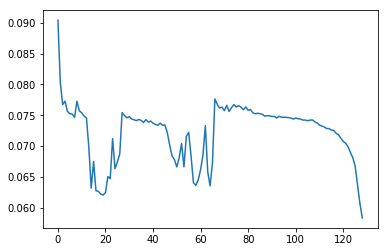

으---------------ᅳᅡ 안어 거 순가ᄅᄋᆫᄋᆫ 근 ᅳᅡ-아   --------가-지 ᄋ  거 ᅵᅵ 가ᅡ아 곤으  그 ᄋ   --거  간 이 거 거 아-----------------------------------------------어요.<eos><eos>
으ᅳᅡ 안어 거 순가ᄅᄋᆫᄋᆫ 근 ᅳᅡ아 가지 ᄋ 거 ᅵ 가아 곤으 그 ᄋ 거 간 이 거 거 아어요.<eos>
혼날까 봐 거짓말을 했는데, 나중에 거짓말을 한 것 때문에 엄마한테 더 혼났어요.<eos>---------


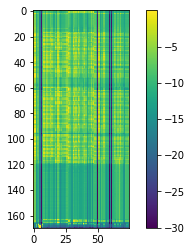

-------------------------------------------------------------------------------------------------------
08-31 12:55:05
Mean Loss: 0.05667680120545364
-------------------------------------------------------------------------------------------------------
08-31 12:55:26
Mean Loss: 0.05529302452906356
-------------------------------------------------------------------------------------------------------
08-31 12:55:47
Mean Loss: 0.05379512427276818
-------------------------------------------------------------------------------------------------------
08-31 12:56:08
Mean Loss: 0.05298940552911318
-------------------------------------------------------------------------------------------------------
08-31 12:56:28
Mean Loss: 0.05185391508814902
-------------------------------------------------------------------------------------------------------
08-31 12:56:49
Mean Loss: 0.05104590290322178
----------------------------------------------------------------------------------------------------

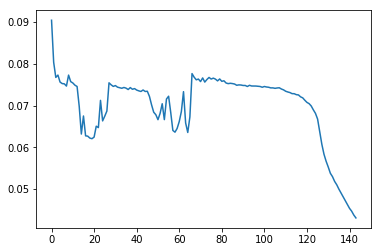

가--------------------든ᅳᆯ 군 소하ᄒ곤아  돈안 다-ᅡ- 경오   -----시-시- 시-ᄀ고에--서--  -----하-ᅳᆫ을 정어-이-가ᄒ하ᅡ----------------------------------------------------------니다.<eos><eos>
가든ᅳᆯ 군 소하ᄒ곤아 돈안 다ᅡ 경오 시시 시고에서 하ᅳᆫ을 정어이가하니다.<eos>
카드를 분실하거나 도난 당할 경우 즉시 신고해서 카드를 정지시켜야 합니다.<eos>--------------------


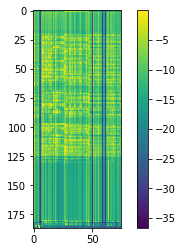

-------------------------------------------------------------------------------------------------------
08-31 13:00:17
Mean Loss: 0.04254663332150463
-------------------------------------------------------------------------------------------------------
08-31 13:00:38
Mean Loss: 0.04182632587459023
-------------------------------------------------------------------------------------------------------
08-31 13:00:59
Mean Loss: 0.04144768421526217
-------------------------------------------------------------------------------------------------------
08-31 13:01:20
Mean Loss: 0.04046211882662806
-------------------------------------------------------------------------------------------------------
08-31 13:01:40
Mean Loss: 0.040279242606555965
-------------------------------------------------------------------------------------------------------
08-31 13:02:02
Mean Loss: 0.039911868980341256
--------------------------------------------------------------------------------------------------

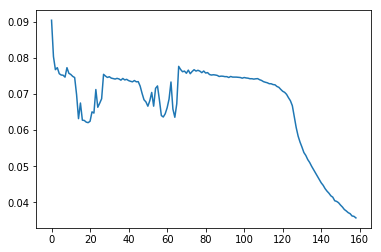

추-----------------------븐ᄋᆯ 선문 조ᄉ사-열ᆯ 거--  -----으-닥자-에거--간-수-가-  ------ᄉᄉᄋ- 기-정에 간-현느ᅵ 거 슬어  ᅡᅡ-다-ᅡ-----------------------------ᆻ다.<eos><eos>
추븐ᄋᆯ 선문 조사열 거 으닥자에거간수가 ᄉᄋ 기정에 간현느ᅵ 거 슬어 ᅡ다ᅡᆻ다.<eos>
최근의 설문 조사 결과 응답자의 과반수가 새 규정에 반대하는 것으로 나타났다.<eos>-----------------


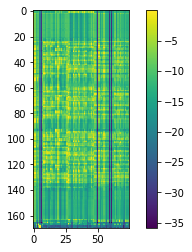

-------------------------------------------------------------------------------------------------------
08-31 13:05:31
Mean Loss: 0.035267780688074825
-------------------------------------------------------------------------------------------------------
08-31 13:05:52
Mean Loss: 0.03504693249966809
-------------------------------------------------------------------------------------------------------
08-31 13:06:13
Mean Loss: 0.03452357509002048
-------------------------------------------------------------------------------------------------------
08-31 13:06:34
Mean Loss: 0.03423923762428538
-------------------------------------------------------------------------------------------------------
08-31 13:06:54
Mean Loss: 0.03367504696068766
-------------------------------------------------------------------------------------------------------
08-31 13:07:15
Mean Loss: 0.03363485165855752
---------------------------------------------------------------------------------------------------

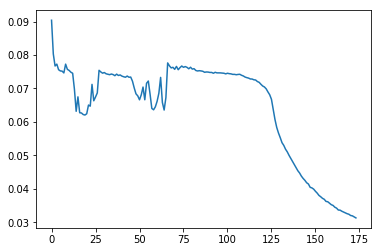

여------------------러-으른 이 고 새-ᄉ서   ----ᄌ자-ᆷᆷᆷ이-   -----대--까ᅡ--   ---ᅵᅳ-ᅵ애--대-   -----다-ᅡᅡ 한족 이 고ᅩ 드ᄅ를 보-실 수  있스ᅳ----ᆸᆸ------------------------------니다.<eos><eos>
여러으른 이 고 새서 잠이 대까 ᅵᅳᅵ애대 다ᅡ 한족 이 고 드를 보실 수 있습니다.<eos>
여러분은 이곳에서 장미, 백합, 튤립 등 다양한 종류의 꽃들을 보실 수 있습니다.<eos>----------


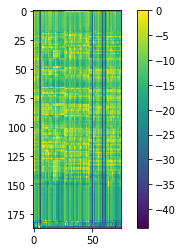

-------------------------------------------------------------------------------------------------------
08-31 13:10:44
Mean Loss: 0.031244368574470466
-------------------------------------------------------------------------------------------------------
08-31 13:11:05
Mean Loss: 0.03119146553702803
-------------------------------------------------------------------------------------------------------
08-31 13:11:25
Mean Loss: 0.03073316521097108
-------------------------------------------------------------------------------------------------------
08-31 13:11:46
Mean Loss: 0.03031554123116779
-------------------------------------------------------------------------------------------------------
08-31 13:12:07
Mean Loss: 0.03018403698749911
-------------------------------------------------------------------------------------------------------
08-31 13:12:28
Mean Loss: 0.030180574097312916
--------------------------------------------------------------------------------------------------

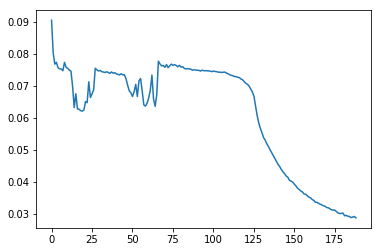

오----------------------리ᅵᄂ는ᆫ  ----메-국이ᅵ 구ᄅ로 자ᅡ-드ᄋᄋ   건니-을 도-거하ᅡᄀ기 이-에   -----개ᅢ-속-대-서-  채-사ᄅ를 다 애 고 시ᅵ------ᆸᆸᆸ---------------------------------니다.<eos><eos>
오리는 메국이 구로 자드ᄋ 건니을 도거하기 이에 개속대서 채사를 다 애 고 십니다.<eos>
우리는 외국인 근로자들의 권익을 보호하기 위해 계속해서 최선을 다할 것입니다.<eos>--------------


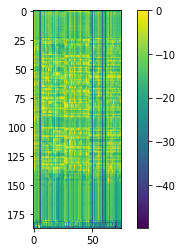

-------------------------------------------------------------------------------------------------------
08-31 13:15:55
Mean Loss: 0.028408447143642435
-------------------------------------------------------------------------------------------------------
08-31 13:16:16
Mean Loss: 0.028282144004669312
-------------------------------------------------------------------------------------------------------
08-31 13:16:36
Mean Loss: 0.028219889756521243
-------------------------------------------------------------------------------------------------------
08-31 13:16:57
Mean Loss: 0.027900140507167406
-------------------------------------------------------------------------------------------------------
08-31 13:17:18
Mean Loss: 0.027752927177848045
-------------------------------------------------------------------------------------------------------
08-31 13:17:38
Mean Loss: 0.027516247412028995
----------------------------------------------------------------------------------------------

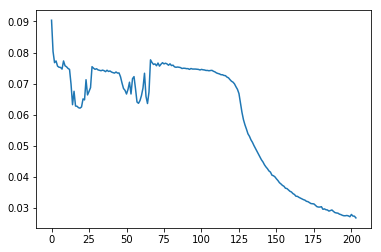

기----------------증-쿰이 대ᄉ소 들엄ᄋ연-서-   -----오ᄅ리는 저-산 도-가-이ᅵ 부좀ᆨ핬하ᄋᄋᆫ 사ᄉᄋᄋ은 ᅢᆫ를아-ᆻᆻ----------------------------------------------------------------어요.<eos><eos>
기증쿰이 대소 들엄연서 오리는 저산 도가이 부좀ᆨ핬하ᄋᆫ 사ᄉ은 ᅢᆫ를았어요.<eos>
기증품이 계속 들어오면서 우리는 저장 공간이 부족하다는 사실을 깨달았어요.<eos>----------------


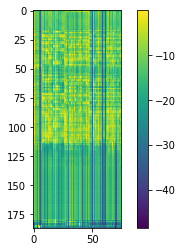

-------------------------------------------------------------------------------------------------------
08-31 13:21:07
Mean Loss: 0.02663223748161866
-------------------------------------------------------------------------------------------------------
08-31 13:21:28
Mean Loss: 0.026635666237701448
-------------------------------------------------------------------------------------------------------
08-31 13:21:49
Mean Loss: 0.026320432675503356
-------------------------------------------------------------------------------------------------------
08-31 13:22:09
Mean Loss: 0.026754024857806556
-------------------------------------------------------------------------------------------------------
08-31 13:22:30
Mean Loss: 0.02765935006148289
-------------------------------------------------------------------------------------------------------
08-31 13:22:51
Mean Loss: 0.026357503751788757
------------------------------------------------------------------------------------------------

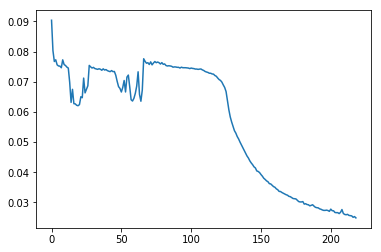

보--------------------이ᅵ러ᄋᄋ  고ᄃ장하ᅡᆻ다ᄂ는 촉게 시 언는  ----오ᅩ-수-가 아- 나- 언나-    남마ᅡᆼ이 안 들 히-이-----ᆸᆸᆸ----------------------------------------------------니다.<eos><eos>
보이러ᄋ 고ᄃ장핬다는 촉게 시 언는 오수가 아 나 언나 남망이 안 들 히입니다.<eos>
보일러가 고장 났다는 초기 신호는 온수가 안 나오거나 난방이 안 될 때입니다.<eos>-----------------


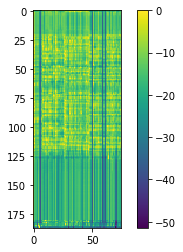

-------------------------------------------------------------------------------------------------------
08-31 13:26:18
Mean Loss: 0.025049895058005305
-------------------------------------------------------------------------------------------------------
08-31 13:26:38
Mean Loss: 0.024971268582597267
-------------------------------------------------------------------------------------------------------
08-31 13:26:59
Mean Loss: 0.024873596902069486
-------------------------------------------------------------------------------------------------------
08-31 13:27:19
Mean Loss: 0.024605694066479403
-------------------------------------------------------------------------------------------------------
08-31 13:27:40
Mean Loss: 0.02454224122764647
-------------------------------------------------------------------------------------------------------
08-31 13:28:00
Mean Loss: 0.02519205179249826
------------------------------------------------------------------------------------------------

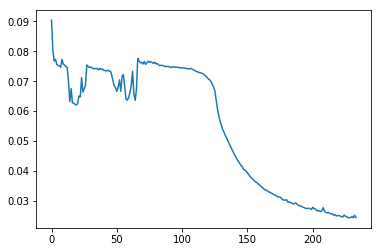

저-----------는 기-가 어-두-은-네--  ----가ᄅ르 ᄉᄉᄅ람이 에-기를   --아ᅡ지 자ᅡᆯᆯᆯ ᄃᆯ르ᅮᅮᅳᆫ ᅡ으ᅳᆯ 말ᅳᅳᆯ  많일들어 와-ᆻᆻ---------------------------------------어요.<eos><eos>
저는 기가 어두은네 가르 ᄉ람이 에기를 아지 잘 ᄃᆯ르ᅮᅳᆫ ᅡ을 말ᅳᆯ 많일들어 왔어요.<eos>
저는 귀가 어두운데 다른 사람의 얘기를 아주 잘 들어 준다는 말을 많이 들어왔어요.<eos>-----------


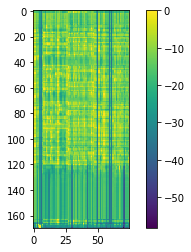

-------------------------------------------------------------------------------------------------------
08-31 13:31:26
Mean Loss: 0.024049823125171458
-------------------------------------------------------------------------------------------------------
08-31 13:31:47
Mean Loss: 0.02570024473032225
-------------------------------------------------------------------------------------------------------
08-31 13:32:07
Mean Loss: 0.024399321222304902
-------------------------------------------------------------------------------------------------------
08-31 13:32:28
Mean Loss: 0.023770862164960157
-------------------------------------------------------------------------------------------------------
08-31 13:32:48
Mean Loss: 0.023599508790517656
-------------------------------------------------------------------------------------------------------
08-31 13:33:09
Mean Loss: 0.023776593560673846
-----------------------------------------------------------------------------------------------

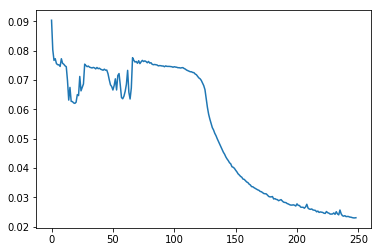

우---------------------리-ᄂ느---ᆫᆫ  -----근ᄋ애ᄋᆯ 노-ᄀᄋ에ᅢᄃ더-나--   ---일요ᄋᆯᆯ 전으-에ᅦ  돌어ᅥᄋ ᄉ수 있을 걸 가ᅡᅡᅡᆼᄀ가하ᅡ-----------------------------------------------------어요.<eos><eos>
우리는 근애ᄋᆯ 노ᄀ에ᅢ더나 일요ᄋᆯ 전으에 돌어ᄋ 수 있을 걸 강가하어요.<eos>
우리는 금요일 오후에 떠나 일요일 저녁에 돌아올 수 있을 거라 생각했어요.<eos>--------------------


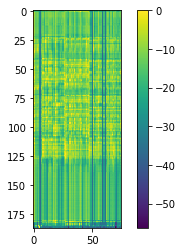

-------------------------------------------------------------------------------------------------------
08-31 13:36:35
Mean Loss: 0.023243197015781113
-------------------------------------------------------------------------------------------------------
08-31 13:36:56
Mean Loss: 0.0226309188663262
-------------------------------------------------------------------------------------------------------
08-31 13:37:18
Mean Loss: 0.022924732096916367
-------------------------------------------------------------------------------------------------------
08-31 13:37:38
Mean Loss: 0.0226346563357369
-------------------------------------------------------------------------------------------------------
08-31 13:37:59
Mean Loss: 0.022558981553399818
-------------------------------------------------------------------------------------------------------
08-31 13:38:19
Mean Loss: 0.022385065860880744
--------------------------------------------------------------------------------------------------

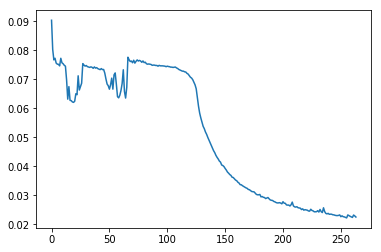

오----------------------리ᄂ는ᆫ  ----매-국이  굴로-자-들에 ᅦ 건니-을 보-요하ᅡᄀ기 이-해    ----개--속데ᅢ-서   처-설을 다알 골이ᅵ------ᆸᆸ-----------------------------------니다.<eos><eos>
오리는 매국이 굴로자들에 ᅦ 건니을 보요하기 이해 개속데ᅢ서 처설을 다알 골입니다.<eos>
우리는 외국인 근로자들의 권익을 보호하기 위해 계속해서 최선을 다할 것입니다.<eos>--------------


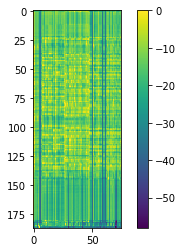

-------------------------------------------------------------------------------------------------------
08-31 13:41:46
Mean Loss: 0.022377477127243375
-------------------------------------------------------------------------------------------------------
08-31 13:42:07
Mean Loss: 0.021847985698050826
-------------------------------------------------------------------------------------------------------
08-31 13:42:27
Mean Loss: 0.02261750235519009
-------------------------------------------------------------------------------------------------------
08-31 13:42:48
Mean Loss: 0.022485848499422964
-------------------------------------------------------------------------------------------------------
08-31 13:43:08
Mean Loss: 0.02227374872326863
-------------------------------------------------------------------------------------------------------
08-31 13:43:29
Mean Loss: 0.022313061274416398
------------------------------------------------------------------------------------------------

KeyboardInterrupt: ignored

In [0]:
EPOCH = 3 * 60 * 4
    
try:
    net.load('gdrive/My Drive/korean-single-speaker-speech-dataset/kss/model_saved/CTC_eval')
except:
    print("Loading Error")
    
for epoch in range(EPOCH):
    
    print(datetime.now().strftime('%m-%d %H:%M:%S'))
    
    net.set_mode('train')
    preloader_train.initialize_batch()
    loss_list_train = list()
    
    while preloader_train.end_flag == False:
        tensor_input, ground_truth, loss_mask, length_list = preloader_train.get_batch()
        pred_tensor, loss = net.train(tensor_input.to(device), ground_truth.to(device), loss_mask.to(device), length_list.to(device))
        loss_list_train.append(loss)

    print("Mean Train Loss: {}".format(np.mean(np.asarray(loss_list_train))))
    loss_history_train.append(np.mean(np.asarray(loss_list_train)))
    
    net.set_mode('eval')
    preloader_eval.initialize_batch()
    loss_list_eval = list()
    
    while preloader_eval.end_flag == False:
        tensor_input, ground_truth_, loss_mask, length_list = preloader_eval.get_batch()
        pred_tensor_, loss = net.train(tensor_input.to(device), ground_truth_.to(device), loss_mask.to(device), length_list.to(device))
        preloader_eval.append(loss)

    print("Mean Evaluation Loss: {}".format(np.mean(np.asarray(loss_list_eval))))
    loss_history_eval.append(np.mean(np.asarray(loss_list_eval)))
    
    
    
    
    
    
    
    net.save('gdrive/My Drive/korean-single-speaker-speech-dataset/kss/model_saved/CTC_eval')
    np.save('gdrive/My Drive/korean-single-speaker-speech-dataset/kss/model_saved/loss_history_train.npy', loss_history_train)
    np.save('gdrive/My Drive/korean-single-speaker-speech-dataset/kss/model_saved/loss_history_eval.npy', loss_history_eval)
    
    
    if ((epoch != 0) and (epoch % 6 == 0)):
        
        plt.figure()
        plt.plot(loss_history_train)
        plt.plot(loss_history_eval)
        plt.show()
        
        _, index = pred_tensor[:, 0, :].max(-1)

        sentence = tokenizer.num2word(index.view(-1))
        print(''.join(sentence))
        index_ = Decode_CTC_Prediction(index)
        sentence_ = tokenizer.num2word(index_)
        print(''.join(sentence_))
        true_sentence = tokenizer.num2word(ground_truth[0, :].detach().numpy().astype(int))
        print(''.join(true_sentence))

        plt.figure()
        plt.imshow(pred_tensor[:, 0, :].detach().cpu().numpy())
        plt.colorbar()
        plt.show()
        
        _, index = pred_tensor_[:, 0, :].max(-1)

        sentence = tokenizer.num2word(index.view(-1))
        print(''.join(sentence))
        index_ = Decode_CTC_Prediction(index)
        sentence_ = tokenizer.num2word(index_)
        print(''.join(sentence_))
        true_sentence = tokenizer.num2word(ground_truth_[0, :].detach().numpy().astype(int))
        print(''.join(true_sentence))

        plt.figure()
        plt.imshow(pred_tensor_[:, 0, :].detach().cpu().numpy())
        plt.colorbar()
        plt.show()
        
        
                        
    print("-------------------------------------------------------------------------------------------------------")